# Анализ рынка недвижимости

**Цель исследования** - установить параметры для определения рыночной стоимости объекта.

**Описание данных**  - данные сервиса Яндекс.Недвижимость, архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

<div align='right'>Проектную работу выполнил студент Гагиев Денис. </div>

---

## Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# загрузка данных
data = pd.read_csv('ссылка скрыта', sep='\t') 

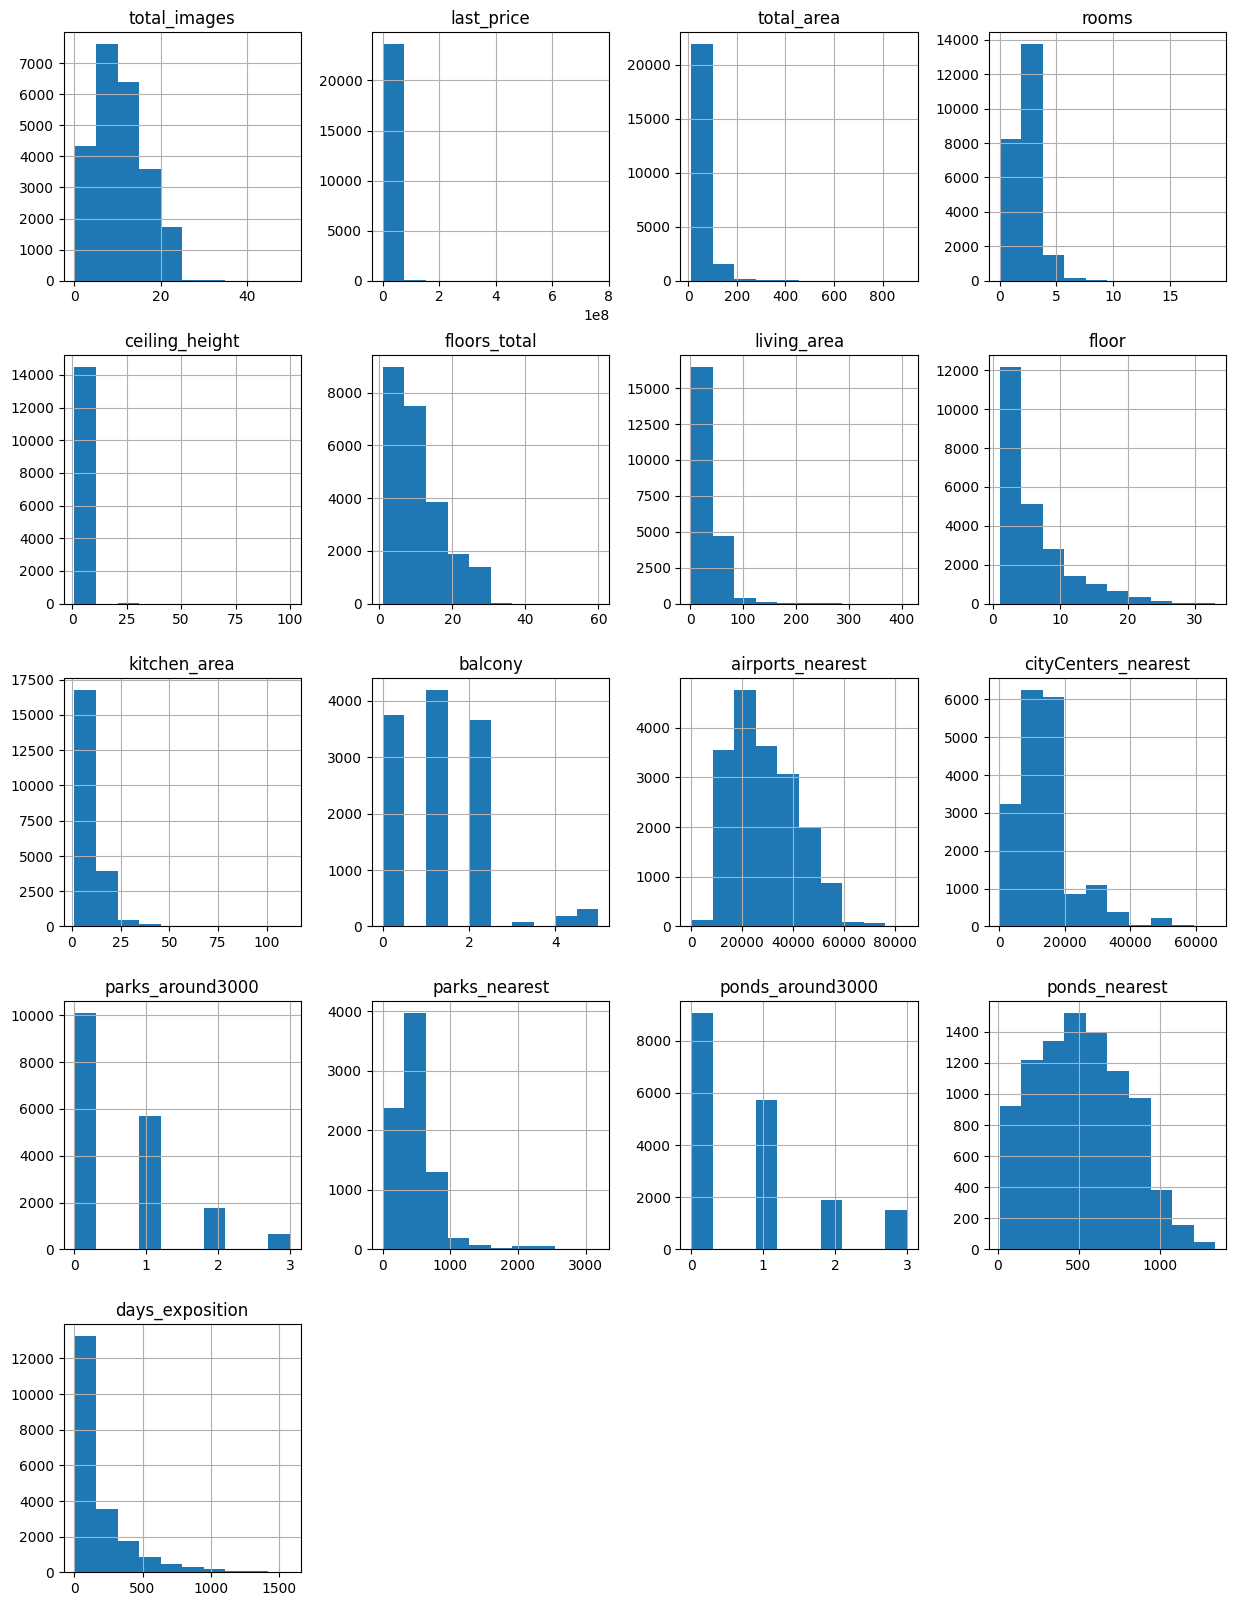

In [3]:
# обзор данных с помощью гистограмм
data.hist(figsize=(15, 20))
plt.show()

При первичном осмотре данных через .info() и .head() видно наличие пропусков в некоторых столбцах, особенно большое колличество пропусков наблюдается в столбце "is_apartment". Не совсем понятна валюта в столбце с ценой, но скорее всего рубли. Не совсем понятен смысл дробных значений в не которых столбцах, как например, "ponds_around3000" или "balcony". Сравнивания значения из таблицы и тип данных .info(), видно, что некоторые столбцы имеют не правильный тип данных, как, пример столбцы с типом данных object или дата в "не своем" формате,  что требует изменений для корректной дальнейшей обработки и изучения данных. Построены гистограммы по данным, некоторые визуализации требуют более детального рассмотрения.

### Предобработка данных

In [4]:
#поиск пропущенных значений
data.isna().sum()

#замена пропусков в столбце "балконы"
data['balcony'] = data['balcony'].fillna(0)

#замена пропусков в столбце "высота потолков" на медиану
data['ceiling_height'] = (data['ceiling_height'].fillna(data['ceiling_height'].mean()))

#замена пропусков в столбце "всего этажей" на 1
for u in data['floor'].unique():
    data.loc[(data['floor'] == u) & (data['floors_total'].isna()), 'floors_total'] = u

#замена пропусков в столбце "жилая площадь" на медиану по колличеству комнат, как тип квартиры
for u in data['rooms'].unique():
    data.loc[(data['rooms'] == u) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == u), 'living_area'].median()

#замена пропусков в столбце "is_apprtment"
data['is_apartment'] = data['is_apartment'].fillna(False) #не уверен в правильности такой логики, убедила когорта

#вывод результата
data.isna().sum()
data.loc[[186, 237]]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.771499,4.0,30.80,4,False,...,12.0,0.0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.771499,1.0,20.75,1,False,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0


<b>Возможные причины возникновения пропусков:</b>
    
   - Балконы - фактическое отсутвие балконов
   - Высота потолков - неожиданный вопрос при составлении объявление, человек не знал или не помнил
   - Этажи - одноэтажное здание
   - Жилая площадь - человек не знал площадь жилой части
   - Аппартаменты - возможно произошел какой-то сбой в данных или при формировании объявление у людей в принципе возникал вопрос, что от них требуется указать, поскольку для меня значения столбца аппартаменты тоже небольшая тайна.
   - Пропуски в столбцах с данными об расстоянии до объектов инфаструктуры могут возникать по причине не правильно указанного адресса или, например, сервис с объявлениям не синхронизировал указанный адрес с точкой на карте. 

In [5]:
#изменение типа данных для даты 
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#is_apartment в bool
data['is_apartment'] = data['is_apartment'].astype('bool')

#этажи с дробями
data['floors_total'] = data['floors_total'].astype('int')

#площадь квартир
data['total_area'] = data['total_area'].astype('int')

Изменения типа для данных необходимо для удобной дальнейшей работы с этими данными и вообще так более красиво. Столбец с апартаментами в принципе подразумевает только логический тип значений. Этажей с дробями не бывает. 

In [6]:
#список слов, которые необходимо удалить:
no_words = [
    'посёлок',
    'поселок',
    'деревня',
    'городского типа',
    'садоводческое некоммерческое товарищество',
    'село',
    'при железнодорожной станции',
    'коттеджный',
    'станции',
    'садовое',
    'некоммерческое',
    'городской',
    'товарищество',
    ''
]

#удаление не нужных префиксов и пробелов:
for word in no_words:
    data['locality_name'] = data['locality_name'].str.replace(word, '').str.strip()
    
data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Теперь каждое название населенного пункта уникально

In [7]:
#обработка значений слишком большой площади 
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] /= 10
data = data.loc[data['ceiling_height'] < 5]

#проверка общей площади квартир, проверена квартира в 900 квадратов, её площадь логически оправдана
#отсеяны квартиры с площадью меньше 15 квадратов 
data = data.loc[data['total_area'] > 15]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23675 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23675 non-null  int64         
 1   last_price            23675 non-null  float64       
 2   total_area            23675 non-null  int64         
 3   first_day_exposition  23675 non-null  datetime64[ns]
 4   rooms                 23675 non-null  int64         
 5   ceiling_height        23675 non-null  float64       
 6   floors_total          23675 non-null  int64         
 7   living_area           23675 non-null  float64       
 8   floor                 23675 non-null  int64         
 9   is_apartment          23675 non-null  bool          
 10  studio                23675 non-null  bool          
 11  open_plan             23675 non-null  bool          
 12  kitchen_area          21411 non-null  float64       
 13  balcony         

Обработана высота потолков, некоторые значения разделены на 10, чтобы принять свой более правдоподобный вид. В тоже время несколько значений полностью отсеяны. 

Большое колличество комнат у некоторых квартир логически оправдана, так как значеней площадей и цены тоже соответствуют. 

Выялены некоторы квартиры с достаточно высокой ценой, но не правдопобной стоимостью. Был вариант умножить эти значения на 10, но поскольку таких квартир совсем немного, то они удалены.

С ценами на момент публикации все нормально. 

С этажами тоже все нормально.

Вертолетной площадки из большого колличеста балконов тоже не наблюдается) 
 

### Посчитайте и добавьте в таблицу новые столбцы

In [8]:
#цена одного квадратного метра
data['one_metr_price'] = data['last_price'] / data['total_area']

#день недели 
data['week_day'] = data['first_day_exposition'].dt.weekday

#месяц публикации
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

#год публикации
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

#тип этажа квартиры
def floor_type(df):
        floor = df['floor']
        floors_total = df['floors_total']
        
        if floor == floors_total:
            return 'последний'
        elif floor == 1:
            return 'первый'
        else: return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis = 1) #axis = 1 переда строк (по умолчанию - столбцы)

#расстояние до центра города в километрах 
data['to_center_km'] = data['cityCenters_nearest']/1000
data['to_center_km'] =data['to_center_km'].fillna(0) #замена пропусков на 0 для преобразования формата в int
data['to_center_km'] = data['to_center_km'].astype('int')

### Проведите исследовательский анализ данных

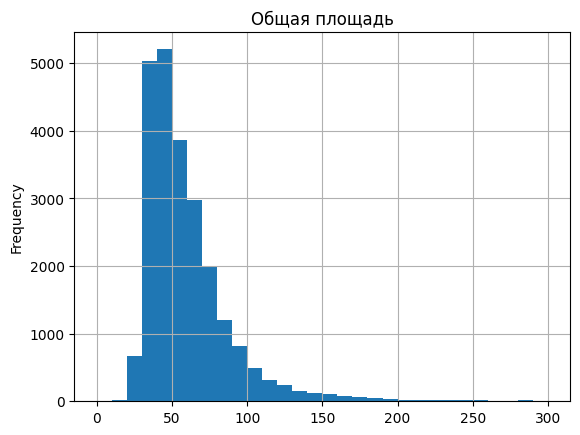

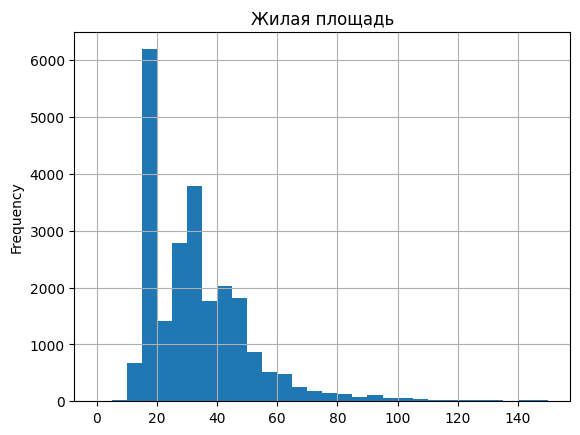

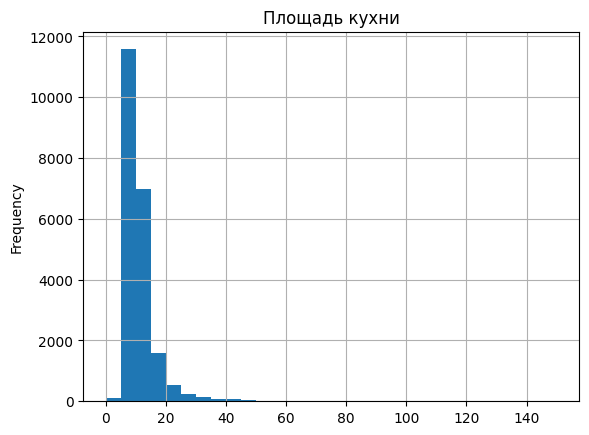

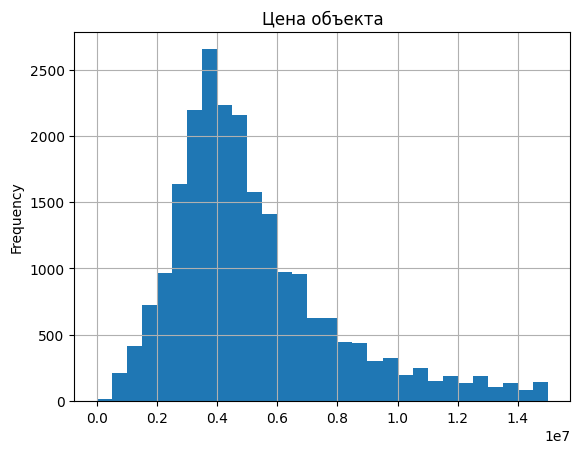

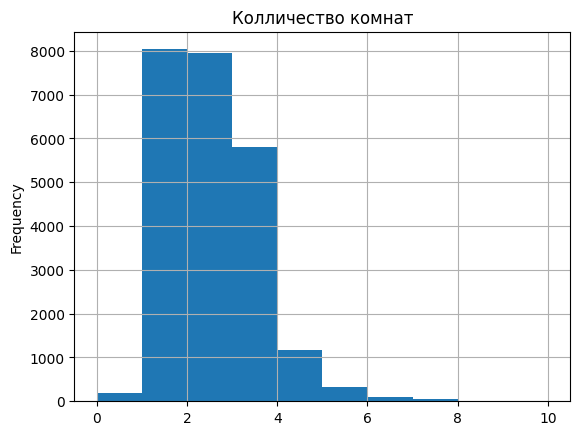

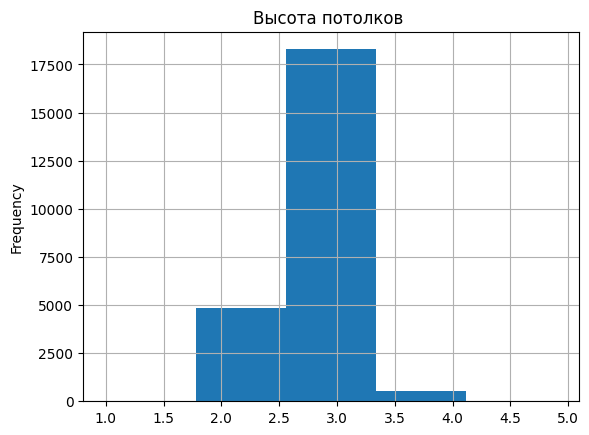

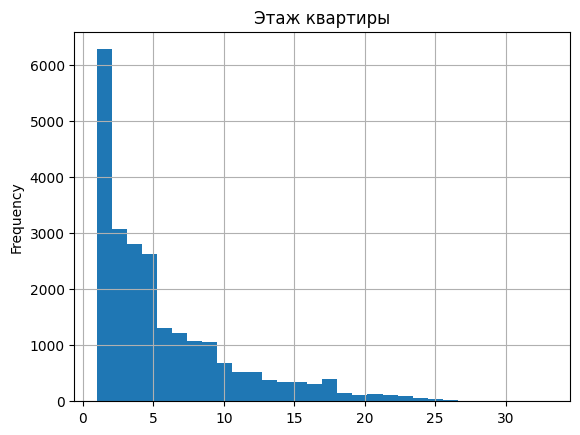

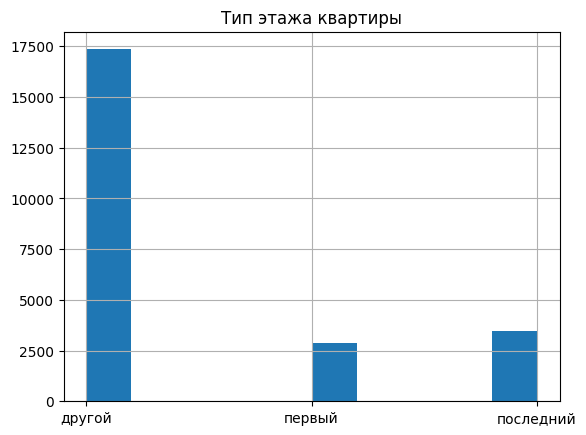

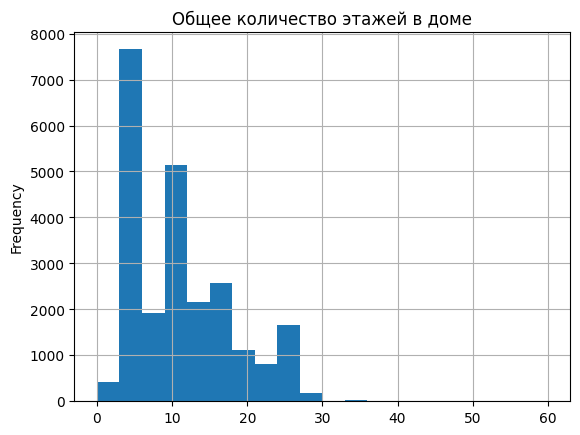

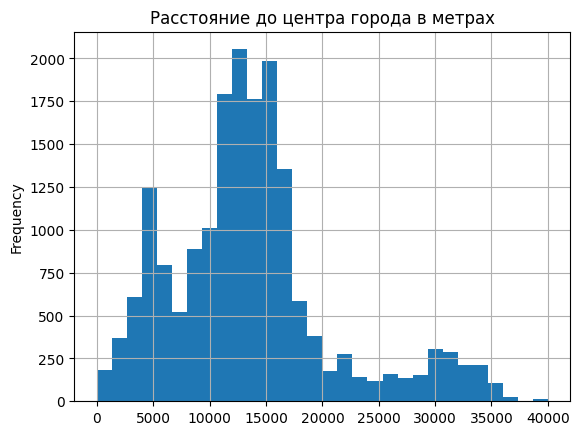

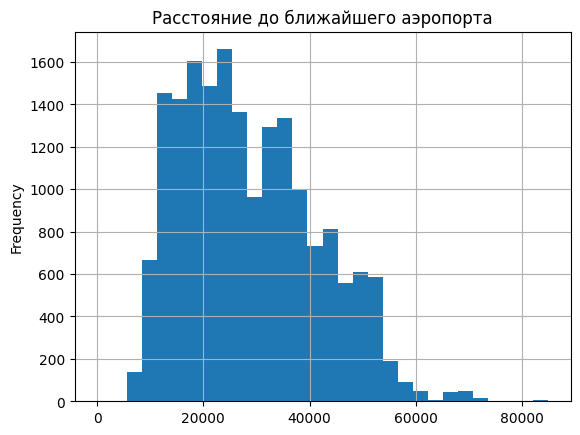

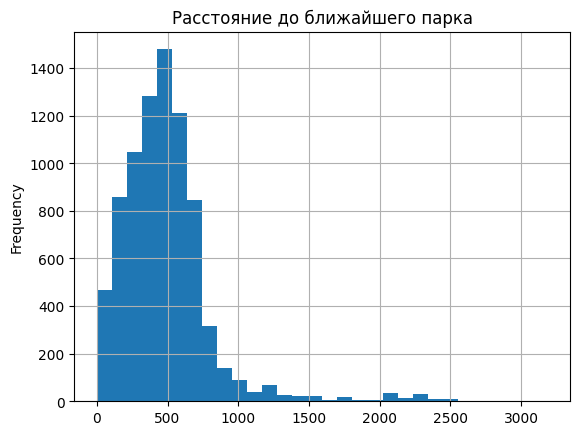

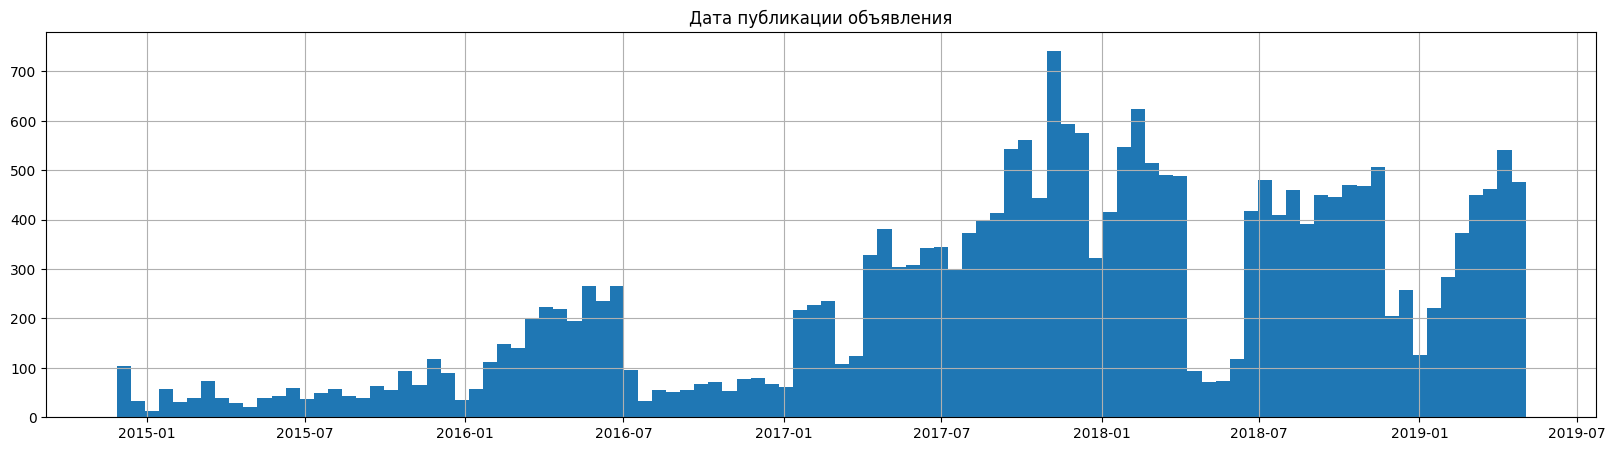

In [14]:
# комментарий студента: изначально хотел написать цикл или функцию, но пошел ручным путем из-за разных параметров
# и вместо условий для замены параметров, мне было легче сделать вручную
# примерный вид цикла: 
# список с именами необходимых столбцов = []
# for column in range(len(список с именами необходимых столбцов)):
#     data[список[column]].plot(hist=........, title=тот же индекс второго списка c переводом)
#     plt.show()
    
# Общая площадь   
data['total_area'].plot(kind='hist', title='Общая площадь', range=(0, 300), bins=30, grid=True)
plt.show()

# Жилая площадь
data['living_area'].plot(kind='hist', title='Жилая площадь', range=(0, 150), bins=30, grid=True)
plt.show()

#  Площадь кухни
data['kitchen_area'].plot(kind='hist', title='Площадь кухни', range=(0, 150), bins=30, grid=True)
plt.show()

# Цена объекта
data['last_price'].plot(kind='hist', title='Цена объекта', range=(0, 15000000), bins=30, grid=True)
plt.show()

# Колличество комнат
data['rooms'].plot(kind='hist', title='Колличество комнат', range=(0, 10), bins=10, grid=True)
plt.show()

# Высота потолков 
data['ceiling_height'].plot(kind='hist', title='Высота потолков ', bins=5, grid=True)
plt.show()

# Этаж квартиры
data['floor'].plot(kind='hist', title='Этаж квартиры', bins=30, grid=True)
plt.show()
data['floor'].describe()

# Тип этажа квартиры
data['floor_type'].hist(grid=True)
plt.title('Тип этажа квартиры')
plt.show()

# Общее количество этажей в доме
data['floors_total'].plot(
    kind='hist', title='Общее количество этажей в доме', range=(0, 60), bins=20, grid=True
)
plt.show()
data.groupby('floors_total')['rooms'].count()

# Расстояние до центра города в метрах
data['cityCenters_nearest'].plot(
    kind='hist', title='Расстояние до центра города в метрах', range=(0, 40000), bins=30, grid=True
)
plt.show()

# Расстояние до ближайшего аэропорта
data['airports_nearest'].plot(
    kind='hist', title='Расстояние до ближайшего аэропорта', bins=30, grid=True
)
plt.show()

# Расстояние до ближайшего парка
data['parks_nearest'].plot(
    kind='hist', title='Расстояние до ближайшего парка', bins=30, grid=True
)
plt.show()

# День и месяц публикации объявления
data['first_day_exposition'].hist(figsize=(20, 5), bins=100)
plt.title('Дата публикации объявления')
plt.show()

**Наблюдения:**

**Общая площадь** Наблюдается нормальное распределение, есть пик в районе 50м2, что логически оправдано. 
Виден большой хвост. В исходных данных максимальная площадь квартиры - 900 метров, эти данные не отсеяны, поскольку стоимость квартир с большой площадью также высокая. 

**Жилая площадь** Также нормальное распределение, немного странным кажется отсутствие пиковых значений от 20 до 25 м2. Но в целом график отражает общую площадь, только со своими значениями. 

**Площадь кухни** Все логически оправдано

**Цена объекта** Наблюдается нормальное распределение с хвостом на в виде более дорогих квартир. Пик гистограммы в районе 4 миллионов рублей. 

**Колличество комнат** Большинство квартир имеют 2-3 комнаты. Ничего необычного не вижу, есть хвост, который оправдан большими и дорогими квартирами. 

**Высота потолков** Эти данные в том числе прошли этап предобработки, сейчас график не показывает ничего удивительного. квартиры с потолками более 5 метров отсеяны, их уделельная доля была совсем небольшая. 

**Этаж квартиры** Больше всего квартир находится на первом этаже. Не вижу ничего странного, что есть квартиры находящиеся и на 33 этаже (максимальное значение). 

**Тип этажа квартиры** Логично, что большинство квартир занимают корзину "другой". В тоже время наблюдаются квартиры на последнем и первом этаже. 

P.S. здесь у меня не получилось построить график через plot посколькуо формат данных не числовой. В тоже время через hist у меня не получилось задать title :(

**Общее количество этажей в доме**  Наблюдаются логически оправданные пики значений. При групировки данных по общему колличеству этажей более отчетливо видно, что много 16-ти этажных зданий, 9-ти, 10-ти, также много 5-ти этажных зданий. 

**Расстояние до центра города в метрах** Больше всего квартир находится от центра примерно в 12 км.

**Расстояние до аэропорта** Большинство квартир находятся примерно в 20км от аэропорта. 

**Расстояние до парка** Парки к квартирами, как правило, находятся близко. Есть и большие значения, возможно это окраины города и новостройки, где еще нет инфаструктуры в виде парков. Можно предположить что есть зависимость между расстоянием до центра города и до парка. 

**Дата публикации** Наблюдается рост колличества объявлений начиная с 2017 года, своих пиковых значений достигает к концу 2018 года. Также весной 2018 года виден резкий спад. Если предположить, что в 2017 должна была наблюдаться тенденция роста, то возможно и здесь есть спад но в форме уменьшения роста колличества объявлений. Также наблюдаются логические спада в новогоднее время каждого года. 

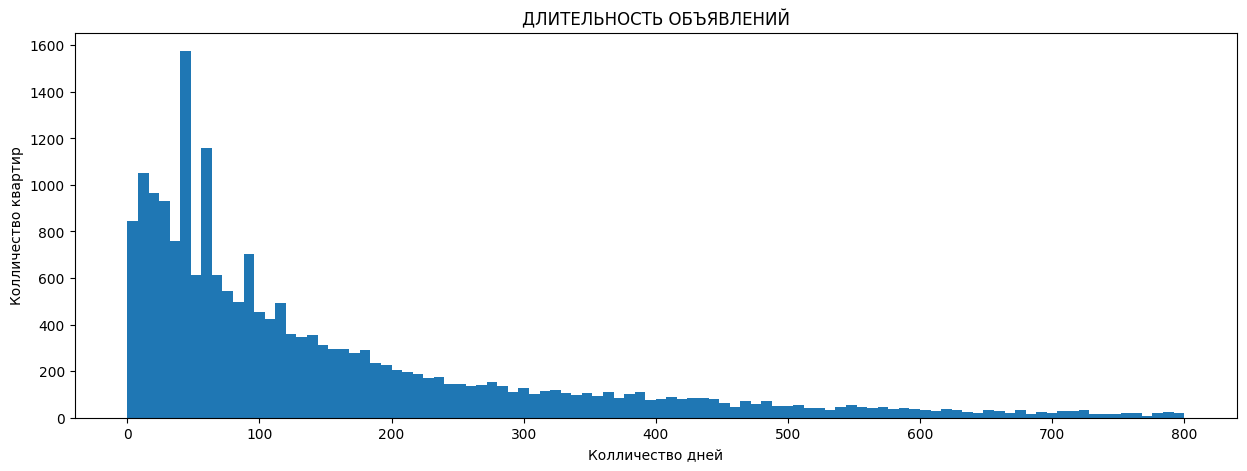

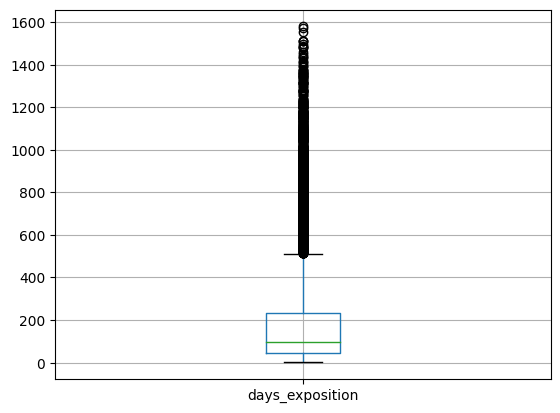

count    20496.000000
mean       180.890954
std        219.733928
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [10]:
#построение гистограммы
data['days_exposition'].plot(
    kind='hist', title='ДЛИТЕЛЬНОСТЬ ОБЪЯВЛЕНИЙ',
    bins=100, figsize=(15, 5), range=(0, 800)
)
plt.xlabel('Колличество дней')
plt.ylabel('Колличество квартир')
plt.show()

#построение ящика с усами
data.boxplot(['days_exposition'])
plt.show()

#дескрайб
data['days_exposition'].describe()

Быстрыми продажами можно считать продажи, произведенные в первый месяц после публикации объявления.

Видно, что среднее равняется 180-ти дням, но после отсечки трех четвертей со значением 232 дня остается слишком много значений. Поэтому, я думаю, правильнее будет сказать, что большая вероятность - это срок продажи квартиры 
в срок, равный медиане (95 дней). 

Долгим сроком продажи квартиры можно считать квартиры проданные в промежутке от Q3=75% до верхнего "уса", это примерно квартиры со сроком продажи от 232 дней до 500, все квартиры с большей длительность продажи можно назвать необычном долгими по сроку продажи. 

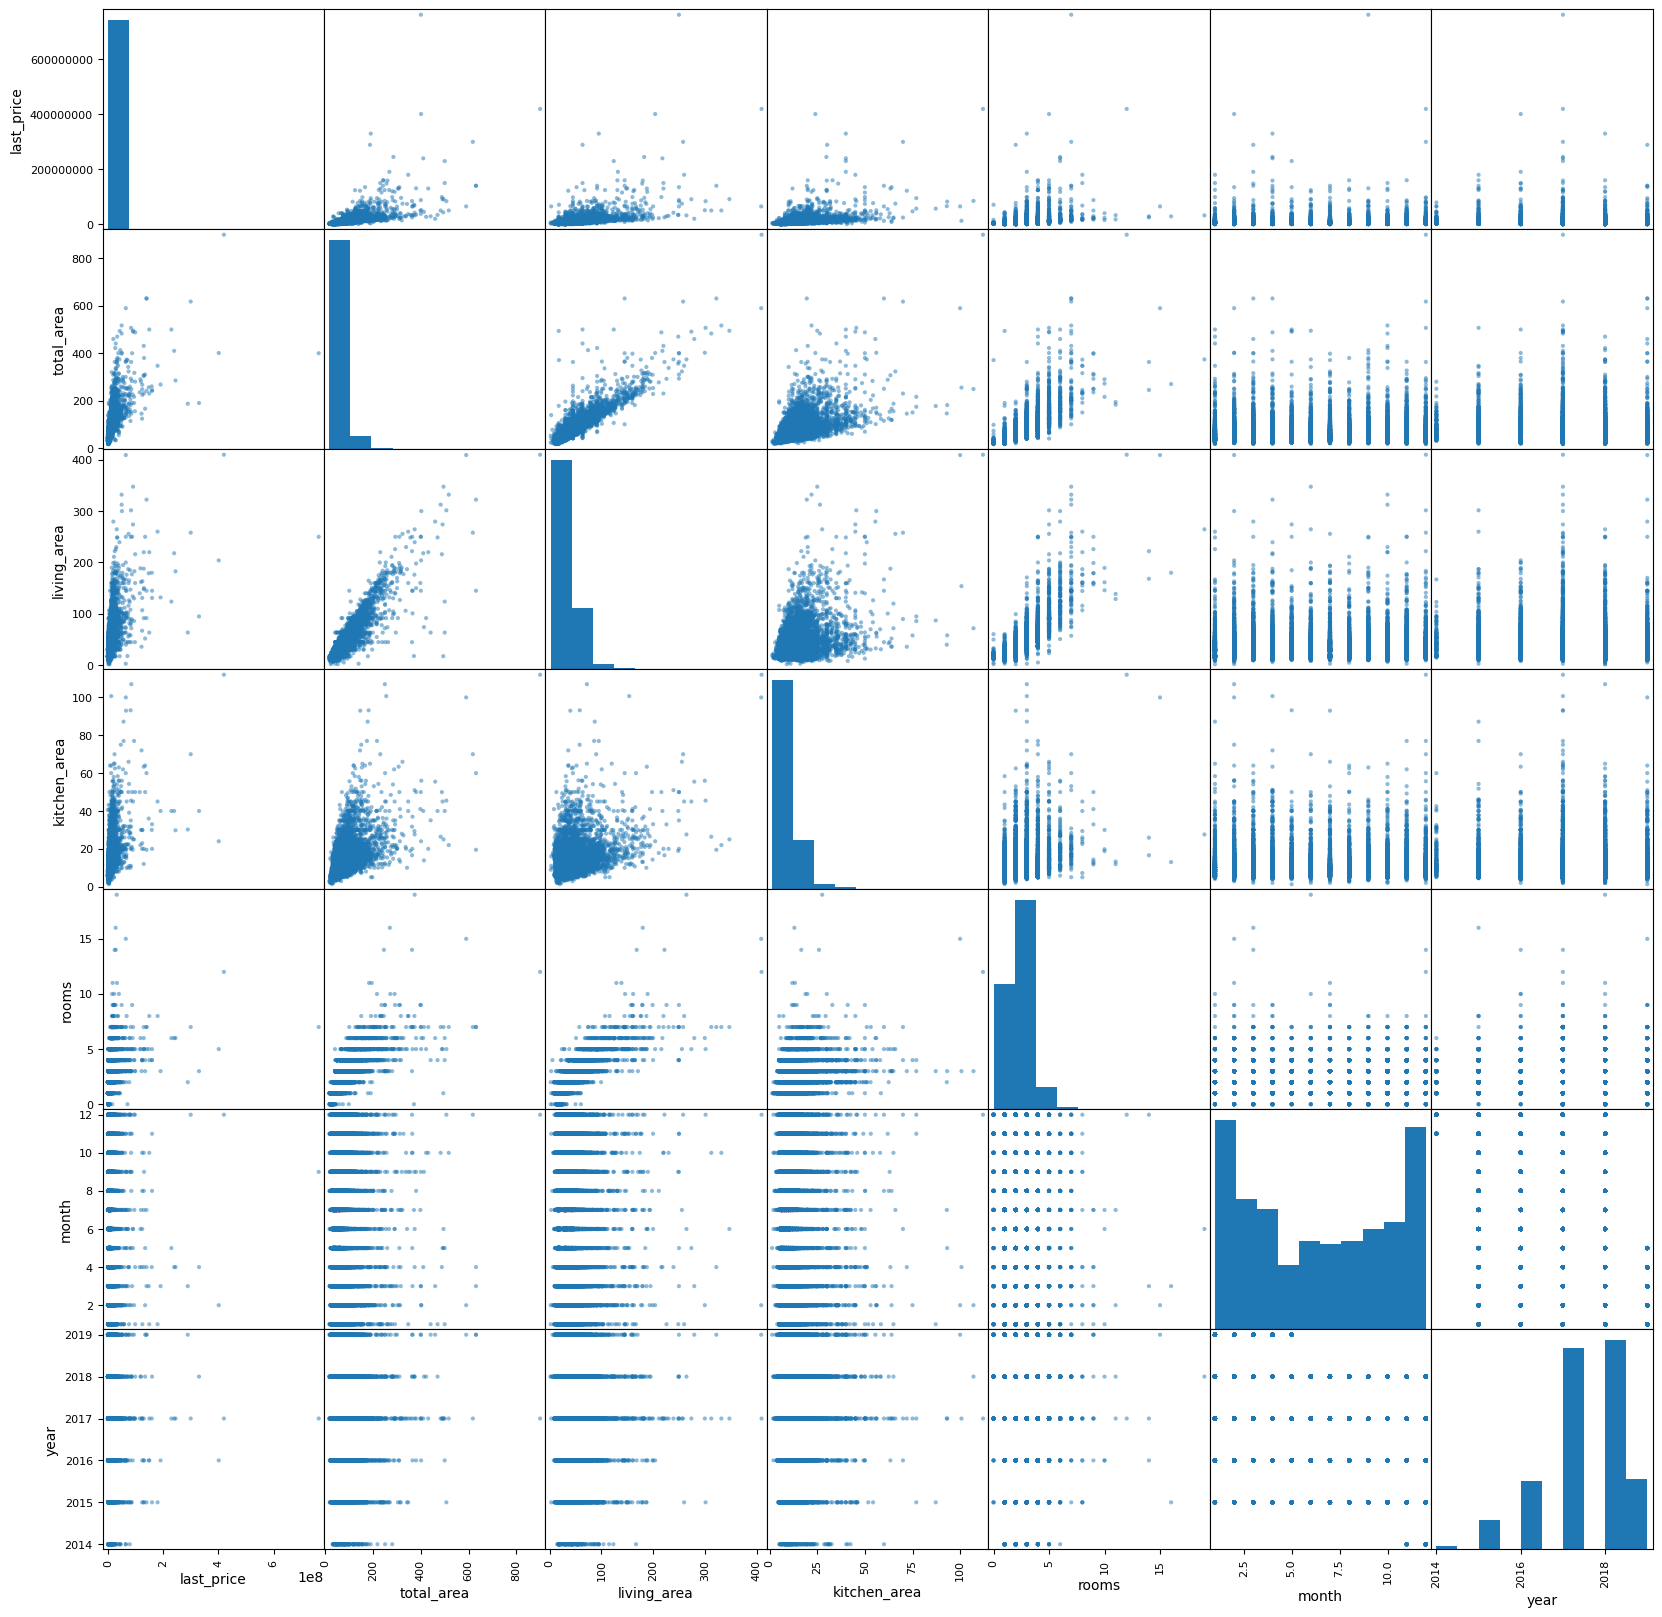

In [11]:
#отсеивание не нужных стобцов 
data_new = data[['last_price','total_area', 'living_area', 'kitchen_area', 'rooms', 'month', 'year', 'floor_type']]

#числовая корреляция
data_new.corr()

#диаграмма рассеяния 
pd.plotting.scatter_matrix(data_new, figsize=(20, 20))
plt.show()

Видна положительная зависимости цены от площадей и колличества комнат. В наибольшей степени цена квартиры зависит от общей
площади, как практически симметрично зависим от жилой площади и площади кухни. В меньшей степени стоимость
квартиры зависит от колличестав комнат, скорее всего это связанно с тем, что основная характериска, влияющая на цену - это квадратный метр, а планировка площади уже может быть разной, не всем нужно много маленьких комнаток, кто-то выберет допустим 2, но большие комнаты.
При построении матрицы диаграмм рассеяния видна также видна некая зависимость, например, видно, что к концу весны стоимость немного выше. Еще случаев высокой цены в 2017 году больше, а самая низкая цена оправданно в 2014. Также цена растет с ростом колличества комнат, но до определенного уровня, потом цена уже не так положительно зависит от колличества комнта, возможно в этих случая больше комнат, но не большая общая площадь.

In [12]:
#data.isnull().sum()
data['for_pivot'] = 1

data_top_city = data.pivot_table(
    index='locality_name', values=['for_pivot', 'total_area', 'last_price' ], 
    aggfunc='sum').sort_values(by='for_pivot', ascending=False
)

#вывод первых 10 по колличеству объявлений
data_top_city = data_top_city.head(10)

#расчет стоимости 1 метра и сортировка по новому столбцу
data_top_city['сost_one_metr'] = data_top_city['last_price'] / data_top_city['total_area']
data_top_city = data_top_city.sort_values(by='сost_one_metr', ascending=False)
data_top_city

,for_pivot,last_price,total_area,сost_one_metr
locality_name,,,,
Санкт-Петербург,15701,1.262467e+11,1012571,124679.382113
Пушкин,369,2.387074e+09,22628,105492.056921
Кудрово,472,2.057301e+09,21781,94453.916716
Парголово,327,1.467600e+09,16767,87529.102344
Мурино,590,2.170293e+09,25853,83947.421963
Шушары,440,1.807556e+09,23580,76656.318872
Колпино,338,1.339839e+09,17928,74734.451473
Гатчина,307,1.070919e+09,15581,68732.389449
Всеволожск,398,1.508049e+09,22200,67930.133559


Наибольшую стоимость 1 квадратного метра имеет Санкт-Петербург. 

Наименьшую стоимость 1 квадратного метра имеет Выборг. 


'Средняя стоимость 1 км:'

726612.4112991879

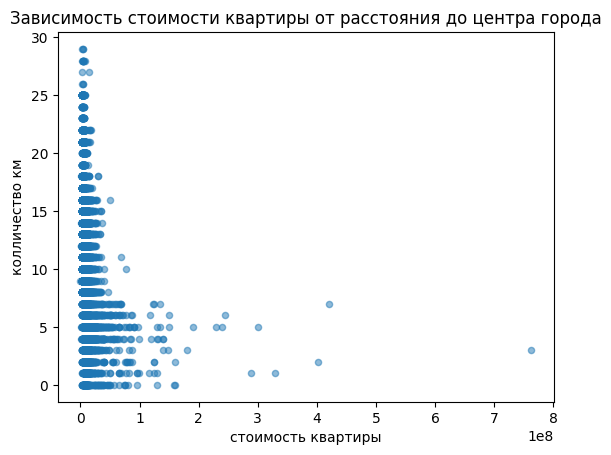

In [13]:
#новая переменная с сортировкой по Питеру
sP_cost = data.loc[data['locality_name'] == 'Санкт-Петербург']

#фильтр для вывода только нужных столбцов
sP_cost = sP_cost[['last_price', 'to_center_km']]

#расчет стоимости 1 км и сброс индекса
sP_cost['сost_one_km'] = sP_cost['last_price'] / sP_cost['to_center_km']
sP_cost.reset_index()

#пришлось создать новую переменную, потому что если вывести mean столбца со стоимостью - то выходит
#какое-то значение inf
pi = sP_cost['last_price'].sum() / sP_cost['to_center_km'].sum()
display("Средняя стоимость 1 км:", pi)
sP_cost.corr()

#соотношение цены и стоимости каждого км
sP_cost.plot(
    x='last_price', y='to_center_km', kind='scatter', alpha=0.5,
    ylabel='колличество км', xlabel='стоимость квартиры',
    title='Зависимость стоимости квартиры от расстояния до центра города'
) 
plt.show()

Средняя стоимость 1 киллометра составляет: 726612 рублей. 
Построена корреляция и диаграмма рассеяния. Выявлено, что стоимость каждой квартиры отрицательно зависит от колличества киллометров до центра, это говорит о том, что квартиры с меньшим колличеством километров к центру города, как правило, дороже.

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    
    
# Анализ данных рынка недвижемости 2015 - 2020 год
---
**Цель исследования** - изучить данные рынка недвижимости , выявить возможные закономерности.

**В рамках исследования выдвинуты следующие гипотезы:**
- на стоимость квартиры влияют такие факторы, как:
    - общей площади;
    - жилой площади;
    - площади кухни;
    - количества комнат;
    - этажа, на котором расположена квартира (первый, последний, другой);
    - даты размещения (день недели, месяц, год).
- колличества объявлений в год сезонно
- стоимость жилья среди фаворит по колличеству объявлений в Санкт-Петербурге самая дорогая
- квартиры, находящиеся ближе к центре имеют более высокую стоимость

**Работа с данными:**
- выявлены и заполнены пропуски в данных;
- обработаны аномальные значения;
- обработаны явные и неявные дубликаты значений;
- обработы неккоректные типы данных.
---
**Гипотеза 1 - на стоимость квартиры влияет ряд приведенных ранее факторов.**

Для проверки гипотезы графически изучена корреляция данных.

Видна положительная зависимости цены от площадей и колличества комнат. 
В наибольшей степени цена квартиры зависит от общей площади, как практически симметрично зависим от жилой площади и площади кухни. 
В меньшей степени стоимость квартиры зависит от колличестав комнат, скорее всего это связанно с тем, что основная характериска, влияющая на цену - это квадратный метр, а планировка площади уже может быть разной, не всем нужно много маленьких комнаток, кто-то выберет допустим 2, но большие комнаты.

Не выявлена зависимость стоимость квартиры от даты публикации объявления.

Таким образом - **гипотеза подтверждена частично** и влияние на стоимость квартиры достоверно оказывает только характериски, связанные с площадью. 

**Гипотеза 2 - колличество объявлений в год сезонно.**

Построена гистограмма колличества объявлений по временной шкале. Виден спад в новогоднее время и дальнейший рост к лету. 

Таким образом - **гипотеза подтвержена** и колличество объявлений действительно имеет сезонный характер. 

**Гипотеза 3 - стоимость жилья в Санкт-Петербурге самая дорогая.**
    
Для проверки гипотезы собраны и отсортированны данные по необходимым признакам. 
    
**Гипотеза подтвержена** и жилье в Санкт-Петербурге действительно самое дорогое, самое дешевое жилье
по колличеству объявлений оказалось в Выборге.    

**Гипотеза 4 - квартиры, находящиеся ближе к центре имеют более высокую стоимость.**
 
Для проверки гипотезы собраны и отсортированны данные по необходимым признакам, произведены математические расчеты и построена корреляция.

**Гипотеза подтверждает**, по мере удаление квартиры от центра её стоимость уменьшается. 
    
    

**Заключение**: таким образом, обработаны и изучены данные рынка недвижимости. Выдвинут ряд предположений, который
    находит своё подтвержение в рамках анализа.  

</div>

